In [71]:
import time
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape
from tensorflow.keras.layers import Flatten, BatchNormalization, Dense, Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
class GAN:
    def __init__(self, dataset_path, image_shape, batch_size, epochs):
        self.dataset_path = dataset_path
        self.image_shape = image_shape
        self.batch_size = batch_size
        self.epochs = epochs

    def get_generator(self):
        generator = Sequential()
        generator.add(Dense(units=4 * 4 * 512,
                            kernel_initializer='glorot_uniform',
                            input_shape=(1, 1, 100)))
        generator.add(Reshape(target_shape=(4, 4, 512)))
        generator.add(BatchNormalization(momentum=0.5))
        generator.add(Activation('relu'))

        generator.add(Conv2DTranspose(filters=256, kernel_size=(5, 5),
                                      strides=(2, 2), padding='same',
                                      data_format='channels_last',
                                      kernel_initializer='glorot_uniform'))
        generator.add(BatchNormalization(momentum=0.5))
        generator.add(Activation('relu'))

        generator.add(Conv2DTranspose(filters=128, kernel_size=(5, 5),
                                      strides=(2, 2), padding='same',
                                      data_format='channels_last',
                                      kernel_initializer='glorot_uniform'))
        generator.add(BatchNormalization(momentum=0.5))
        generator.add(Activation('relu'))

        generator.add(Conv2DTranspose(filters=64, kernel_size=(5, 5),
                                      strides=(2, 2), padding='same',
                                      data_format='channels_last',
                                      kernel_initializer='glorot_uniform'))
        generator.add(BatchNormalization(momentum=0.5))
        generator.add(Activation('relu'))

        generator.add(Conv2DTranspose(filters=3, kernel_size=(5, 5),
                                      strides=(2, 2), padding='same',
                                      data_format='channels_last',
                                      kernel_initializer='glorot_uniform'))
        generator.add(Activation('tanh'))

        optimizer = Adam(lr=0.00015, beta_1=0.5)
        generator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=None)

        return generator

    def get_discriminator(self):
        discriminator = Sequential()
        discriminator.add(Conv2D(filters=64, kernel_size=(5, 5),
                                 strides=(2, 2), padding='same',
                                 data_format='channels_last',
                                 kernel_initializer='glorot_uniform',
                                 input_shape=self.image_shape))
        discriminator.add(LeakyReLU(0.2))

        discriminator.add(Conv2D(filters=128, kernel_size=(5, 5),
                                 strides=(2, 2), padding='same',
                                 data_format='channels_last',
                                 kernel_initializer='glorot_uniform'))
        discriminator.add(BatchNormalization(momentum=0.5))
        discriminator.add(LeakyReLU(0.2))

        discriminator.add(Conv2D(filters=256, kernel_size=(5, 5),
                                 strides=(2, 2), padding='same',
                                 data_format='channels_last',
                                 kernel_initializer='glorot_uniform'))
        discriminator.add(BatchNormalization(momentum=0.5))
        discriminator.add(LeakyReLU(0.2))

        discriminator.add(Conv2D(filters=512, kernel_size=(5, 5),
                                 strides=(2, 2), padding='same',
                                 data_format='channels_last',
                                 kernel_initializer='glorot_uniform'))
        discriminator.add(BatchNormalization(momentum=0.5))
        discriminator.add(LeakyReLU(0.2))

        discriminator.add(Flatten())
        discriminator.add(Dense(1))
        discriminator.add(Activation('sigmoid'))

        optimizer = Adam(lr=0.0002, beta_1=0.5)
        discriminator.compile(loss='binary_crossentropy',
                              optimizer=optimizer,
                              metrics=None)

        return discriminator

    def get_adversarial(self, generator, discriminator):
        gan = Sequential()
        discriminator.trainable = False
        gan.add(generator)
        gan.add(discriminator)

        optimizer = Adam(lr=0.00015, beta_1=0.5)
        gan.compile(loss='binary_crossentropy', optimizer=optimizer,
                    metrics=None)
        return gan

    def load_data(self):
        image_data_generator = ImageDataGenerator()
        dataset_generator = image_data_generator.flow_from_directory(
            self.dataset_path, target_size=(self.image_shape[0], self.image_shape[1]),
            batch_size=self.batch_size,
            class_mode=None)

        return dataset_generator

    def save_images(self, generated_images, epoch_no, batch_no):
        plt.figure(figsize=(8, 8), num=2)
        gs1 = gridspec.GridSpec(8, 8)
        gs1.update(wspace=0, hspace=0)

        for i in range(64):
            ax1 = plt.subplot(gs1[i])
            ax1.set_aspect('equal')
            image = generated_images[i, :, :, :]
            image += 1
            image *= 127.5
            fig = plt.imshow(image.astype(np.uint8))
            plt.axis('off')
            fig.axes.get_xaxis().set_visible(False)
            fig.axes.get_yaxis().set_visible(False)

        plt.tight_layout()
#         save_name = 'new_images/generated_epoch' + str(
#             epoch_no + 1) + '_batch' + str(batch_no + 1) + '.png'
#         if not os.path.exists('new_images'):
#             os.mkdir('new_images')
#         plt.savefig(save_name, bbox_inches='tight', pad_inches=0)
        plt.pause(0.0000000001)
        plt.show()

    def train_model(self):
        generator = self.get_generator()
        discriminator = self.get_discriminator()
        gan = self.get_adversarial(generator, discriminator)

        # Load dataset
        dataset_generator = self.load_data()

        number_of_batches = 150

        # Variables that will be used to plot the losses from the discriminator and
        # the adversarial models
        adversarial_loss = np.empty(shape=1)
        discriminator_loss = np.empty(shape=1)
        batches = np.empty(shape=1)

        # Allow plot updates inside for loop
        plt.ion()

        current_batch = 0

        # Begin training
        for epoch in range(self.epochs):

            print("Epoch " + str(epoch + 1) + "/" + str(self.epochs) + " :")

            for batch_number in range(number_of_batches):

                start_time = time.time()

                real_images = dataset_generator.next()

                # Normalize the images between -1 and 1
                real_images /= 127.5
                real_images -= 1

                # The last batch is smaller than the other ones, so we need to
                # take that into account
                current_batch_size = real_images.shape[0]

                # Generate noise
                noise = np.random.normal(0, 1,
                                         size=(current_batch_size,) + (1, 1, 100))

                # Generate images
                generated_images = generator.predict(noise)

                # Add some noise to the labels that will be
                # fed to the discriminator
                real_y = (np.ones(current_batch_size) -
                          np.random.random_sample(current_batch_size) * 0.2)
                fake_y = np.random.random_sample(current_batch_size) * 0.2

                # Let's train the discriminator
                discriminator.trainable = True

                d_loss = discriminator.train_on_batch(real_images, real_y)
                d_loss += discriminator.train_on_batch(generated_images, fake_y)

                discriminator_loss = np.append(discriminator_loss, d_loss)

                # Now it's time to train the generator
                discriminator.trainable = False

                noise = np.random.normal(0, 1,
                                         size=(current_batch_size * 2,) +
                                              (1, 1, 100))

                # We try to mislead the discriminator by giving the opposite labels
                fake_y = (np.ones(current_batch_size * 2) -
                          np.random.random_sample(current_batch_size * 2) * 0.2)

                g_loss = gan.train_on_batch(noise, fake_y)
                adversarial_loss = np.append(adversarial_loss, g_loss)
                batches = np.append(batches, current_batch)

                time_elapsed = time.time() - start_time
                
                # Display and plot the results
                if batch_number==0 or ((batch_number + 1) % 50 == 0 and
                        current_batch_size == self.batch_size):
                    print("     Batch " + str(batch_number + 1) + "/" +
                          str(number_of_batches) +
                          " generator loss | discriminator loss : " +
                          str(g_loss) + " | " + str(d_loss) + ' - batch took ' +
                          str(time_elapsed) + ' s.')
                    
                # Each 150 batches show and save images
                if ((batch_number + 1) % 150 == 0 and
                        current_batch_size == self.batch_size):
                    self.save_images(generated_images, epoch, batch_number)

                current_batch += 1

            # Save the model weights each 5 epochs
            if (epoch + 1) % 50 == 0:
                discriminator.trainable = True
                if not os.path.exists('models'):
                    os.mkdir('models')
                generator.save('models/generator_epoch' + str(epoch) + '.hdf5')
                discriminator.save('models/discriminator_epoch' +
                                   str(epoch) + '.hdf5')
        return adversarial_loss, discriminator_loss

In [ ]:
dataset_path = '../input/pokemon-images-dataset/pokemon_jpg'
batch_size = 64
image_shape = (64, 64, 3)
epochs = 125
gan = GAN(dataset_path, image_shape, batch_size, epochs)
adversarial_loss, discriminator_loss = gan.train_model()

In [ ]:
g_loss_all = np.mean(adversarial_loss[:epochs*150].reshape(-1, 150), axis=1)
d_loss_all = np.mean(discriminator_loss[:epochs*150].reshape(-1, 150), axis=1)
plt.figure(1)
plt.plot(range(epochs), g_loss_all, color='red', label='Generator Loss')
plt.plot(range(epochs), d_loss_all, color='green', label='Discriminator Loss')
plt.title("GAN Training")
plt.xlabel("Epochs Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.plot(range(epochs), g_loss_all, color='red')
plt.title("Generator Loss")
plt.show()

In [ ]:
plt.plot(range(epochs), d_loss_all, color='green')
plt.title("Discriminator Loss")
plt.show()

In [ ]:
! zip -r ./models models

In [ ]:
! cp models/generator_epoch124.hdf5 generator_epoch124.hdf5 

In [ ]:
! cp models/discriminator_epoch124.hdf5 discriminator_epoch124.hdf5 

In [ ]:
! rm -rf models
! rm -rf new_images

In [73]:
lodad_model = tf.keras.models.load_model("generator_epoch124.hdf5")

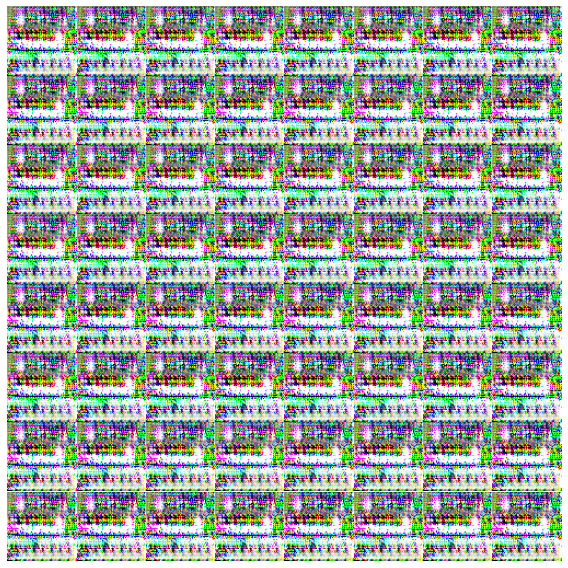

In [86]:
noise = np.random.normal(0, 1,size=(64,) + (1, 1, 100))
generated_images = lodad_model.predict(noise)

plt.figure(figsize=(8, 8), num=2)
gs1 = gridspec.GridSpec(8, 8)
gs1.update(wspace=0, hspace=0)

for i in range(64):
    ax1 = plt.subplot(gs1[i])
    ax1.set_aspect('equal')
    image = generated_images[i, :, :, :]
    image += 1
    image *= 127.5
    fig = plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()